**🧠Customer Churn Prediction ML Pipeline🧠**
* *Predict whether a customer will churn (i.e., stop using a service), based on user behavior and account data.*

In [100]:
# 1. to handle the data
import pandas as pd
import numpy as np
from scipy import stats

# to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
# pipeline
from sklearn.pipeline import Pipeline
# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error,mean_squared_error,r2_score

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')



**LOADING THE DATASET**

In [101]:
import pandas as pd

# Replace 'your_file.csv' with your actual filename or data source
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape) 

(7043, 21)


In [102]:
# load dataset
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# print all column
pd.set_option('display.max_columns', None)
# print first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [103]:
# This helps to identify if there are any glaring issues such as missing data, incorrect data types, or anomalies in the data.

# Summary info
df.info()

# Check for missing values
df.isnull().sum()

# Summary statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


*Impute with Forward Fill or Backward Fill:*
* If your data is time-series or sequential in nature, you can fill missing values with the previous (forward fill) or next (backward fill) value.
* If you do not want to impute values and would prefer to remove rows with missing data, you can drop those rows.

In [104]:
# Convert 'TotalCharges' to numeric and coerce errors (turns bad values into NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where TotalCharges or Churn is NaN
df = df.dropna(subset=['TotalCharges', 'Churn'])

print(df.shape)  

(7032, 21)


In [105]:
# Standardize values in 'Churn' before mapping
df['Churn'] = df['Churn'].str.strip().str.lower()
df['Churn'] = df['Churn'].map({'yes': 1, 'no': 0})

# Double check mapping
print(df['Churn'].unique())  

[0 1]


**Splitting Data into Features and Target**
* split your data into features (X) and the target variable (y). Since Churn is likely your target variable, you'll separate it from the rest of the columns.

In [106]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

In [107]:
X = pd.get_dummies(X, drop_first=True)

**Split Data into Training and Testing Sets**
* Before training a machine learning model, you need to split the data into training and testing sets.

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(5625, 30) (1407, 30)


**Choose and Train a Baseline Model**
* Start with something simple like Logistic Regression to set a performance baseline.


In [109]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Predict on the test data
lr_y_pred = lr_model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_class_report = classification_report(y_test, lr_y_pred)

# Display results
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print("Confusion Matrix:")
print(lr_conf_matrix)
print("Classification Report:")
print(lr_class_report)

Logistic Regression Accuracy: 0.7853589196872779
Confusion Matrix:
[[917 116]
 [186 188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.55       374

    accuracy                           0.79      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.79      0.78      1407



In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Instantiate the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred)

# Display results
print(f"Random Forest Accuracy: {rf_accuracy}")
print("Confusion Matrix:")
print(rf_conf_matrix)
print("Classification Report:")
print(rf_class_report)

Random Forest Accuracy: 0.7853589196872779
Confusion Matrix:
[[927 106]
 [196 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



In [111]:
import lightgbm as lgb

# Instantiate the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Fit the model to the training data
lgb_model.fit(X_train, y_train)

# Predict on the test data
lgb_y_pred = lgb_model.predict(X_test)

# Evaluate the model
lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_conf_matrix = confusion_matrix(y_test, lgb_y_pred)
lgb_class_report = classification_report(y_test, lgb_y_pred)

# Display results
print(f"LightGBM Accuracy: {lgb_accuracy}")
print("Confusion Matrix:")
print(lgb_conf_matrix)
print("Classification Report:")
print(lgb_class_report)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
LightGBM Accuracy: 0.7910447761194029
Confusion Matrix:
[[925 108]
 [186 188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71   

In [112]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**Set Up the Pipeline:**



In [113]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [114]:
# Predict
y_pred = pipeline.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7633262260127932
Confusion Matrix:
 [[898 135]
 [198 176]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      1033
           1       0.57      0.47      0.51       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.76      1407



WE ARE GETTING getting 76.3% accuracy, which is a solid baseline—but the recall for class 1 (churned customers) is only 0.47, which might be a concern if our business goal is to catch more churners (which is usually the case).
* High accuracy is driven by predicting non-churners correctly (class imbalance).
* Recall for churners is low – you’re missing over half the actual churned customers.
* F1-score for class 1 (churners) is low → room to improve.

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define your pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameter grid to tune
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 500],
    'xgb__max_depth': [3, 6, 10],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.5],
    'xgb__min_child_weight': [1, 5, 10]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'xgb__subsample': 0.7, 'xgb__n_estimators': 500, 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0, 'xgb__colsample_bytree': 1.0}
Accuracy: 0.7960199004975125


**Model Tuning and Optimization**
* Hyperparameter Tuning:
Even if StandardScaler is working well, We can still tune the hyperparameters of your LightGBM model to improve performance. we can use techniques like GridSearchCV or RandomizedSearchCV to fine-tune the following parameters:

* learning_rate

* n_estimators

* max_depth

* subsample

* colsample_bytree

* min_child_weight

* gamma

In [116]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.05],
    'xgb__n_estimators': [100, 500, 1000],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}


**Model Validation**
* Cross-Validation:
it’s good practice to evaluate your model's performance using cross-validation, ensuring that the model generalizes well to unseen data. Cross-validation helps avoid overfitting and assesses the model's stability.

In [117]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

Cross-Validation Scores: [0.77967306 0.79673063 0.76529161 0.78876245 0.78733997]
Mean CV Accuracy: 0.7835595442822466


 Model Interpretation
Feature Importance: For models like LightGBM, you can visualize the importance of each feature to understand how the model is making its decisions.

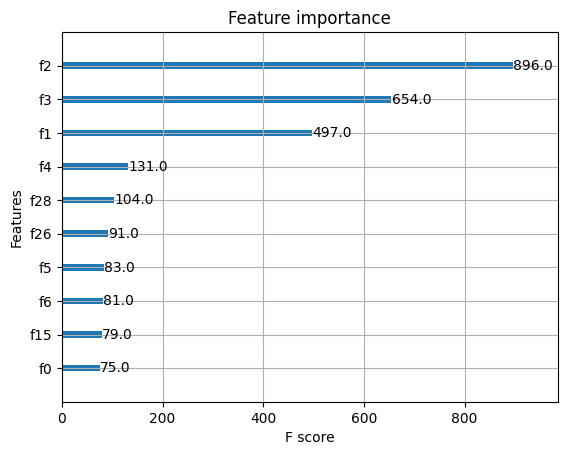

In [118]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Make sure to fit the pipeline first
pipeline.fit(X_train, y_train)

# Extract the XGB model from the pipeline
model = pipeline.named_steps['xgb']

# Feature importance plot
plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")

AUC: 0.6930685765461689


The AUC score ranges from 0 to 1:

AUC = 1: Perfect model (ideal case).

AUC = 0.5: Model performs no better than random guessing.

AUC < 0.5: The model is worse than random guessing.

our AUC score of 0.693 is relatively good, indicating that the model is performing better than random guessing but there's still room for improvement.

Save Your Trained Model:
You can save the trained model to a file using joblib or pickle.

In [120]:
import joblib

# Save the model
joblib.dump(pipeline, 'xgb_pipeline_model.pkl')

['xgb_pipeline_model.pkl']

Load the Model and Make Predictions:
When you want to use the model, load it back and use it for predictions:

In [121]:
# Load the saved model
model = joblib.load('xgb_pipeline_model.pkl')

# Make predictions
y_pred = model.predict(X_test)

If you still want to deploy your model as an API or web app, you can use FastAPI or Flask locally or on cloud platforms like Heroku, AWS, or Google Cloud.

You can:

* Use FastAPI to create an API that accepts input data and returns predictions.

* Deploy the FastAPI app on a cloud service like Heroku, AWS Lambda, or Google Cloud Functions.